## Part I - WeatherPy

In this example, you'll be creating a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator. To accomplish this, you'll be utilizing a [simple Python library](https://pypi.python.org/pypi/citipy), the [OpenWeatherMap API](https://openweathermap.org/api), and a little common sense to create a representative model of weather across world cities.

Your first objective is to build a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

After each plot add a sentence or too explaining what the code is and analyzing.

Your next objective is to run linear regression on each relationship, only this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude):

* Northern Hemisphere - Temperature (F) vs. Latitude
* Southern Hemisphere - Temperature (F) vs. Latitude
* Northern Hemisphere - Humidity (%) vs. Latitude
* Southern Hemisphere - Humidity (%) vs. Latitude
* Northern Hemisphere - Cloudiness (%) vs. Latitude
* Southern Hemisphere - Cloudiness (%) vs. Latitude
* Northern Hemisphere - Wind Speed (mph) vs. Latitude
* Southern Hemisphere - Wind Speed (mph) vs. Latitude

After each pair of plots explain what the linear regression is modelling such as any relationships you notice and any other analysis you may have.

Your final notebook must:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
* Perform a weather check on each of the cities using a series of successive API calls.
* Include a print log of each city as it's being processed with the city number and city name.
* Save a CSV of all retrieved data and a PNG image for each scatter plot.

# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [29]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
import scipy.stats as st
from scipy.stats import linregress
import csv
import os

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output Path & File (CSV)
output_dir = os.path.join("..", "output_data")
output_data_file = os.path.join(output_dir, "cities.csv")

# Input Path & File (CSV)
input_dir = os.path.join("..", "input_data")
input_data_file = os.path.join(input_dir, "cities.csv")

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [30]:
# Does our intput file exist?
exists = os.path.isfile(input_data_file)
if exists == True:
    df_weather = pd.read_csv(input_data_file)
    cities = df_weather["City"]
else:
    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = []

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
    lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
    lat_lngs = zip(lats, lngs)
    
    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)
# end if

# Print the city count to confirm sufficient count
len(cities)

548

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [31]:
if exists == False:
    # Variables
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"
    city_index = 0
    df_weather = pd.DataFrame({"City": [], 
                               "DT": [], 
                               "Country": [], 
                               "Lat": [], 
                               "Lon": [], 
                               "Temp": [], 
                               "Color": [], 
                               "Feels_Like": [], 
                               "Hi": [], 
                               "Low": [], 
                               "Cloudiness": [],
                               "Weather": [], 
                               "Humidity": [], 
                               "Wind": [] 
                              })

    for city in cities:
        # Build query URL
        query_url = f"{url}q={city}&APPID={weather_api_key}&units={units}"
        
        # Get weather data
        weather_response = requests.get(query_url)
        weather_json = weather_response.json()
        
        # What city is next?
        print(f"Trying to get information on '{city}' right meow.")
        
        try:
            # Colors
            # =IF(H2>=80, "red", IF(H2>=55, "orange", IF(H2>=32, "green", "blue")))
            city_temp = weather_json["main"]["temp_max"]
            if city_temp >= 80:
                color = "red"
            elif city_temp >= 55:
                color = "orange"
            elif city_temp >= 32:
                color = "green"
            else:
                color = "blue"
            # end if
            
            df_weather = df_weather.append({"City": city, 
                                            "DT": weather_json["dt"], 
                                            "Country": weather_json["sys"]["country"], 
                                            "Lat": weather_json["coord"]["lat"],
                                            "Lon": weather_json["coord"]["lon"], 
                                            "Temp": weather_json["main"]["temp"], 
                                            "Color": color,
                                            "Feels_Like": weather_json["main"]["feels_like"], 
                                            "Hi": weather_json["main"]["temp_max"], 
                                            "Low": weather_json["main"]["temp_min"], 
                                            "Cloudiness": weather_json["clouds"]["all"], 
                                            "Weather": weather_json["weather"][0]["description"], 
                                            "Humidity": weather_json["main"]["humidity"], 
                                            "Wind": weather_json["wind"]["speed"]}, ignore_index=True)
            
            # API didn't timeout or, otherwise, fail
            city_id = weather_json["id"]
            print(f"API call for '{city}' (ID:{city_id}, series_index = {city_index}) was successful.")
            print(f"{weather_json}")
            print("--------------------------------------------------------------------------------")
            
        except (KeyError, IndexError):
            print(f"API failed for the city '{city}', series_index = {city_index}... skipping.")
            print("--------------------------------------------------------------------------------")
        
        # Keep track of this for some reason
        city_index += 1
        
        # Because we can only call this API 60 times per minute
        # Sleep for 1 second
        time.sleep(1)
    # end for
    
    # Save our dataframe to a csv file, in case we need to run this data again
    df_weather.to_csv(output_data_file, mode = "w", index=False)
# end if

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [32]:
# Convert Unix Date to Readable DateTime
df_weather["DateTime"] = pd.to_datetime(df_weather["DT"], unit="s")

# Now, for a bit of formatting
df_weather["Lat"] = df_weather["Lat"].astype(float)
df_weather["Lat"] = df_weather["Lat"].astype(float)
df_weather["Lon"] = df_weather["Lon"].astype(float)
df_weather["Temp"] = df_weather["Temp"].astype(float)
df_weather["Feels_Like"] = df_weather["Feels_Like"].astype(float)
df_weather["Hi"] = df_weather["Hi"].astype(float)
df_weather["Low"] = df_weather["Low"].astype(float)
df_weather["Cloudiness"] = df_weather["Cloudiness"].astype(float)
df_weather["Humidity"] = df_weather["Humidity"].astype(float)
df_weather["Wind"] = df_weather["Wind"].astype(float)

# Store the total number of cities for later use
total_cities = len(df_weather)

# Print Dataframe to Console
df_weather

,City,DT,Country,Lat,Lon,Temp,Color,Feels_Like,Hi,Low,Cloudiness,Weather,Humidity,Wind,DateTime
0,saskylakh,1.579887e+09,RU,71.92,114.08,-27.94,blue,-47.51,-27.94,-27.94,100.0,overcast clouds,87.0,22.28,2020-01-24 17:25:27
1,castro,1.579887e+09,BR,-24.79,-50.01,74.53,orange,74.10,74.53,74.53,26.0,light rain,61.0,6.71,2020-01-24 17:22:08
2,hermanus,1.579887e+09,ZA,-34.42,19.23,73.00,orange,75.72,73.00,73.00,0.0,clear sky,81.0,5.99,2020-01-24 17:24:13
3,cape town,1.579887e+09,ZA,-33.93,18.42,69.94,orange,65.70,73.00,69.01,0.0,clear sky,77.0,14.99,2020-01-24 17:24:33
4,puerto ayora,1.579887e+09,EC,-0.74,-90.35,82.71,red,79.54,86.00,79.00,40.0,scattered clouds,58.0,16.11,2020-01-24 17:26:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,talcahuano,1.579887e+09,CL,-36.72,-73.12,75.20,orange,67.66,75.20,75.20,32.0,scattered clouds,53.0,17.22,2020-01-24 17:37:26
544,arman,1.579887e+09,RU,59.70,150.17,-14.73,blue,-27.49,-14.73,-14.73,0.0,clear sky,84.0,10.51,2020-01-24 17:37:29
545,bud,1.579887e+09,US,39.45,-86.18,41.74,green,36.59,44.01,39.20,90.0,overcast clouds,100.0,5.82,2020-01-24 17:37:30
546,deputatskiy,1.579887e+09,RU,69.30,139.90,-36.53,blue,-44.63,-36.53,-36.53,3.0,clear sky,96.0,1.83,2020-01-24 17:37:31


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

In the following figure, each dot represents 1 of 548 cities that were randomly selected.
for this analysis. The color of the dot represents the city's forecasted temperature range:
    * Red = Hot (>= 80° F)
    * Orange = Warm (>= 55° F)
    * Green = Cool (>= 32° F)
    * Blue = Cold (< 32° F)
I have plotted each city's latitude, or proximity to the equator (which is latitude 0),
 against the forecasted, ambient, air temperature (high) today.
As expected, warmer cities are closer to the equator.


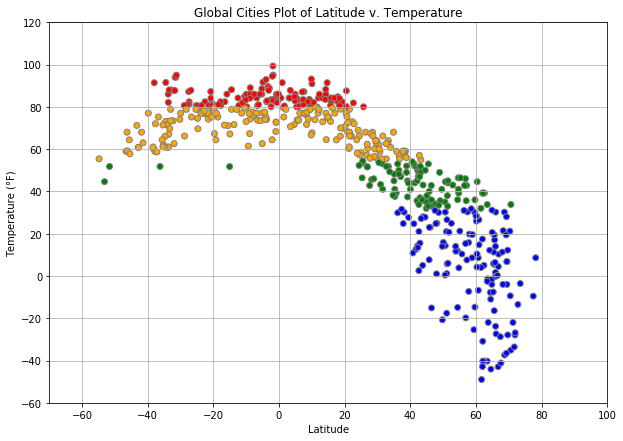

In [33]:
# Plot this bad boy
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()

ax.scatter(df_weather["Lat"], df_weather["Hi"], c=df_weather["Color"], edgecolors="grey", marker="o")

# Formatting
ax.set_xlabel("Latitude")
ax.set_ylabel("Temperature (°F)")
ax.set_xlim(-70, 100)
ax.set_ylim(-60, 120)
ax.grid(True)
plt.title("Global Cities Plot of Latitude v. Temperature")

# Show the chart
print(f"In the following figure, each dot represents 1 of {total_cities} cities that were randomly selected.")
print("for this analysis. The color of the dot represents the city's forecasted temperature range:")
print("    * Red = Hot (>= 80° F)")
print("    * Orange = Warm (>= 55° F)")
print("    * Green = Cool (>= 32° F)")
print("    * Blue = Cold (< 32° F)")
print("I have plotted each city's latitude, or proximity to the equator (which is latitude 0),")
print(" against the forecasted, ambient, air temperature (high) today.")
print("As expected, warmer cities are closer to the equator.")
plt.show()

# Save our figure
save_file = output_data_file = os.path.join(output_dir, "Cities_LatvTemp.png")
fig.savefig(save_file)

#### Latitude vs. Humidity Plot

In the following figure, each diamond represents 1 of 548 cities that were randomly selected.
The color of the diamond represents the city's forecasted temperature range:
    * Red = Hot (>= 80° F)
    * Orange = Warm (>= 55° F)
    * Green = Cool (>= 32° F)
    * Blue = Cold (< 32° F)
We are plotting each city's latitude, or proximity to the equator (which is latitude 0),
against the forecasted humidity (%) for today.
I decided to keep the colors because it adds another dimension to the chart: Temperature.
I expected to see higher humidity in the cities with warmer temperatures.
But as you can see, humidity isn't reserved for just the warmer cities of the world.


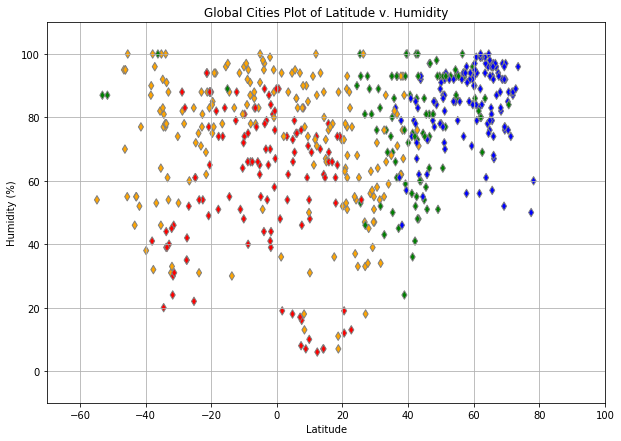

In [34]:
# Plot this bad boy
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()

ax.scatter(df_weather["Lat"], df_weather["Humidity"], c=df_weather["Color"], edgecolors="grey", marker="d")

# Formatting
ax.set_xlabel("Latitude")
ax.set_ylabel("Humidity (%)")
ax.set_xlim(-70, 100)
ax.set_ylim(-10, 110)
ax.grid(True)
plt.title("Global Cities Plot of Latitude v. Humidity")

# Show the chart
print(f"In the following figure, each diamond represents 1 of {total_cities} cities that were randomly selected.")
print("The color of the diamond represents the city's forecasted temperature range:")
print("    * Red = Hot (>= 80° F)")
print("    * Orange = Warm (>= 55° F)")
print("    * Green = Cool (>= 32° F)")
print("    * Blue = Cold (< 32° F)")
print("We are plotting each city's latitude, or proximity to the equator (which is latitude 0),")
print("against the forecasted humidity (%) for today.")
print("I decided to keep the colors because it adds another dimension to the chart: Temperature.")
print("I expected to see higher humidity in the cities with warmer temperatures.")
print("But as you can see, humidity isn't reserved for just the warmer cities of the world.")
plt.show()

# Save our figure
save_file = output_data_file = os.path.join(output_dir, "Cities_LatvHum.png")
fig.savefig(save_file)

#### Latitude vs. Cloudiness Plot

In the following figure, each dot represents 1 of 548 cities that were randomly selected.
The color of the dot represents the city's forecasted temperature range:
    * Red = Hot (>= 80° F)
    * Orange = Warm (>= 55° F)
    * Green = Cool (>= 32° F)
    * Blue = Cold (< 32° F)
We are plotting each city's latitude, or proximity to the equator (which is latitude 0),
against the forecasted cloudiness (%) today.
Aparently, it's both cloudy and not cloudy at every latitude.


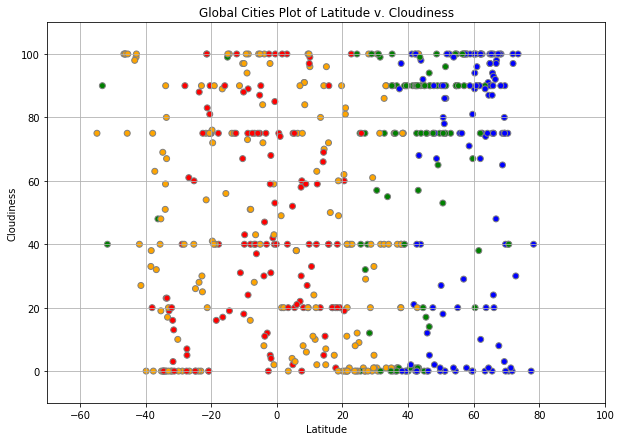

In [35]:
# Plot this bad boy
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()

ax.scatter(df_weather["Lat"], df_weather["Cloudiness"], c=df_weather["Color"], edgecolors="grey", marker="o")

# Formatting
ax.set_xlabel("Latitude")
ax.set_ylabel("Cloudiness")
ax.set_xlim(-70, 100)
ax.set_ylim(-10, 110)
ax.grid(True)
plt.title("Global Cities Plot of Latitude v. Cloudiness")

# Show the chart
print(f"In the following figure, each dot represents 1 of {total_cities} cities that were randomly selected.")
print("The color of the dot represents the city's forecasted temperature range:")
print("    * Red = Hot (>= 80° F)")
print("    * Orange = Warm (>= 55° F)")
print("    * Green = Cool (>= 32° F)")
print("    * Blue = Cold (< 32° F)")
print("We are plotting each city's latitude, or proximity to the equator (which is latitude 0),")
print("against the forecasted cloudiness (%) today.")
print("Aparently, it's both cloudy and not cloudy at every latitude.")
plt.show()

# Save our figure
save_file = output_data_file = os.path.join(output_dir, "Cities_LatvClouds.png")
fig.savefig(save_file)

#### Latitude vs. Wind Speed Plot

In the following figure, each dot represents 1 of 548 cities that were randomly selected.
The color of the dot represents the city's forecasted temperature range:
    * Red = Hot (>= 80° F)
    * Orange = Warm (>= 55° F)
    * Green = Cool (>= 32° F)
    * Blue = Cold (< 32° F)
We are plotting each city's latitude, or proximity to the equator (which is latitude 0),
against the forecasted wind speed (mph) today.
No latitude appears to be significantly windier today (aside from a few outliers in the colder areas).


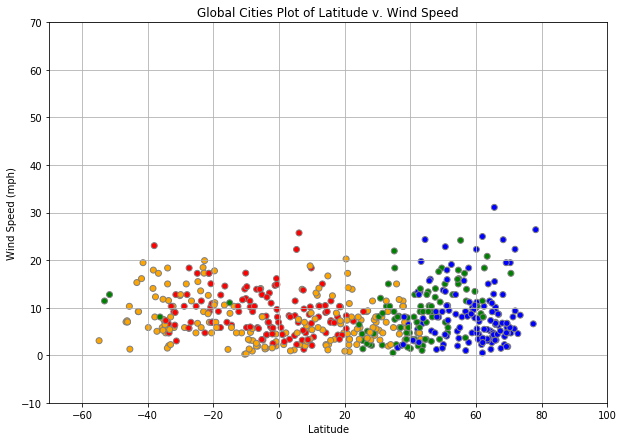

In [36]:
# Plot this bad boy
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()

ax.scatter(df_weather["Lat"], df_weather["Wind"], c=df_weather["Color"], edgecolors="grey", marker="o")

# Formatting
ax.set_xlabel("Latitude")
ax.set_ylabel("Wind Speed (mph)")
ax.set_xlim(-70, 100)
ax.set_ylim(-10, 70)
ax.grid(True)
plt.title("Global Cities Plot of Latitude v. Wind Speed")

# Show the chart
print(f"In the following figure, each dot represents 1 of {total_cities} cities that were randomly selected.")
print("The color of the dot represents the city's forecasted temperature range:")
print("    * Red = Hot (>= 80° F)")
print("    * Orange = Warm (>= 55° F)")
print("    * Green = Cool (>= 32° F)")
print("    * Blue = Cold (< 32° F)")
print("We are plotting each city's latitude, or proximity to the equator (which is latitude 0),")
print("against the forecasted wind speed (mph) today.")
print("No latitude appears to be significantly windier today (aside from a few outliers in the colder areas).")
plt.show()

# Save our figure
save_file = output_data_file = os.path.join(output_dir, "Cities_LatvWind.png")
fig.savefig(save_file)

## Linear Regression

In [37]:
# OPTIONAL: Create a function to create Linear Regression plots
def PlotLinearRegression(x_values, y_values, colors, y_label, x_min, x_max, y_min, y_max, title, image_name):
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

    # Get regression values (mx+b)
    regress_values = x_values * slope + intercept

    # Plot our results
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()

    ax.scatter(x_values, y_values, c=colors, edgecolors="grey", marker="o")
    plt.plot(x_values, regress_values, "b-")

    # Formatting
    plt.xlabel("Latitude")
    plt.ylabel(y_label)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    plt.title(title)

    # Show the chart
    print(f"The correlation coefficient is: {rvalue}")
    plt.show()

    # Save our figure
    save_file = output_data_file = os.path.join(output_dir, image_name)
    fig.savefig(save_file)
# end def

In [38]:
# Northern Hemisphere Cities & Count
df_weather_north = df_weather[df_weather.Lat >= 0]
citcnt_north = len(df_weather_north)

# Southern Hemisphere Cities & Count
df_weather_south = df_weather[df_weather.Lat < 0]
citcnt_south = len(df_weather_south)

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

IMPORTANT INFORMATION:

Each dot in the charts below represents 1 of 548 cities around the world that were randomly selected
    for this analysis. Each dot also has a color that corresponds to that city's ambient air temperature for today
    (if pulled from the OpenWeatherMap API). Though not all of the charts are plotting air temperature, I found that
    for those plots the data is more interesting with temperature as a 3rd dimension.
    The dot colors correspond to the following temperature ranges:
    * Red = Hot (>= 80° F)
    * Orange = Warm (>= 55° F)
    * Green = Cool (>= 32° F)
    * Blue = Cold (< 32° F)
One last thing, the blue lines in these charts represent the regression, marking the data's trend line.
-----------------------
This first chart plots only Northern Hemisphere cities (374 of them).
In the following 2 charts, We are plotting each city's latitude, or proximity to the equator (which is latitude 0),
against the forecasted ambient air temperature (High) for to

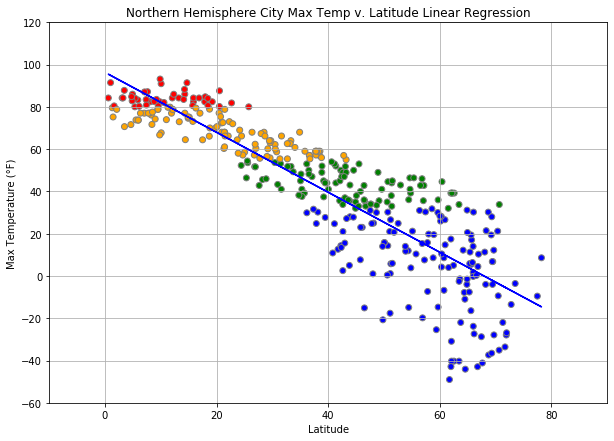

In [39]:
# Provide a brief explanation of what is being charted
print("IMPORTANT INFORMATION:")
print("")
print(f"Each dot in the charts below represents 1 of {total_cities} cities around the world that were randomly selected")
print("    for this analysis. Each dot also has a color that corresponds to that city's ambient air temperature for today")
print("    (if pulled from the OpenWeatherMap API). Though not all of the charts are plotting air temperature, I found that")
print("    for those plots the data is more interesting with temperature as a 3rd dimension.")
print("    The dot colors correspond to the following temperature ranges:")
print("    * Red = Hot (>= 80° F)")
print("    * Orange = Warm (>= 55° F)")
print("    * Green = Cool (>= 32° F)")
print("    * Blue = Cold (< 32° F)")
print("In addition, the blue lines in these charts represent the regression, marking the data's trend line.  And for each pair")
print("    of charts between the Northern and Southern Hemispheres, the chart dimensions are the same.")
print("-----------------------")
print(f"This first chart plots only Northern Hemisphere cities ({citcnt_north} of them).")
print("In the following 2 charts, We are plotting each city's latitude, or proximity to the equator (which is latitude 0),")
print("against the forecasted ambient air temperature (High) for today.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_north["Lat"], df_weather_north["Hi"], df_weather_north["Color"], 
                     "Max Temperature (°F)", -10, 90, -60, 120, 
                     "Northern Hemisphere City Max Temp v. Latitude Linear Regression", "NH_TempvLat.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

This chart is the same as the previous chart but for 174 cities in the Southern Hemisphere.
As before, cities closer to the equator tend to have higher daily air temps, as expected.
The blue regression line also shows the same trend.
-----------------------
OBSERVATIONS:
* Both charts show the same trend.  Cities nearest to the equator tend to have higher ambient air temps.
* While the analysis works fine showing the trend above, the data is skewed a bit.
    - Northern Hemisphere data was taken in the middle of Winter. So, all of the temperatures are the coldest of the year
        However, the average daily temps of cities close to the equator don't change much over the course of the year
        so, those temperatures are not affected. And that skews our data for the Northern Hemisphere.
    - Southern Hemisphere data was taken in the middle of Summer. So, warmer temperatures are exaggeratedly warm
        except, of course, for the cities near the equator.
    - Also, the Northern 

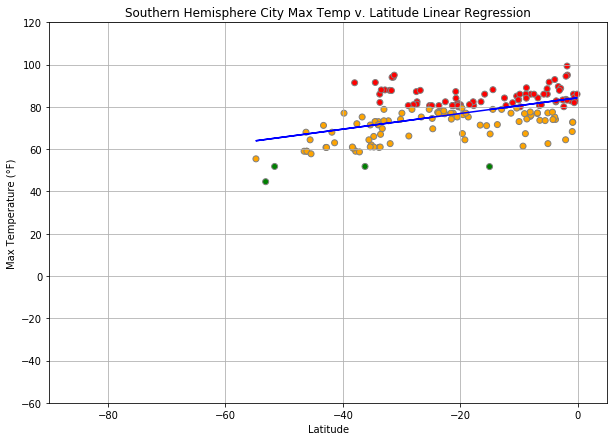

In [49]:
# Provide a brief explanation of what is being charted
print(f"This chart is the same as the previous chart but for {citcnt_south} cities in the Southern Hemisphere.")
print("As before, cities closer to the equator tend to have higher daily air temps, as expected.")
print("The blue regression line also shows the same trend.")
print("-----------------------")
print("OBSERVATIONS:")
print("* Both charts show the same trend.  Cities nearest to the equator tend to have higher ambient air temps.")
print("* While the analysis works fine showing the trend above, the data is skewed a bit.")
print("    - Northern Hemisphere data was taken in the middle of Winter. So, all of the temperatures are the coldest of the year")
print("        However, the average daily temps of cities close to the equator don't change much over the course of the year")
print("        so, those temperatures are not affected. And that skews our data for the Northern Hemisphere.")
print("    - Southern Hemisphere data was taken in the middle of Summer. So, warmer temperatures are exaggeratedly warm")
print("        except, of course, for the cities near the equator.")
print("    - Also, the Northern Hemisphere has 7/8ths of the worlds land mass so we have more data from cities in the North.")
print("        I give credit to that fact to my Geology Professor at OU who didn't see Northern and Southern Hemispheres.")
print("        Instead, he saw the 'Land (80% land, 20% water)' and 'Water (89% water, 11% land)' Hemispheres, respectively.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_south["Lat"], df_weather_south["Hi"], df_weather_south["Color"], 
                     "Max Temperature (°F)", -90, 5, -60, 120, 
                     "Southern Hemisphere City Max Temp v. Latitude Linear Regression", "SH_TempvLat.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The next two charts plot each city's % Humdity against the city's latitude.
This first chart plots Northern Hemisphere cities. The color is there to add that 3rd dimension: temp.
-----------------------
The correlation coefficient is: 0.45191635932397783


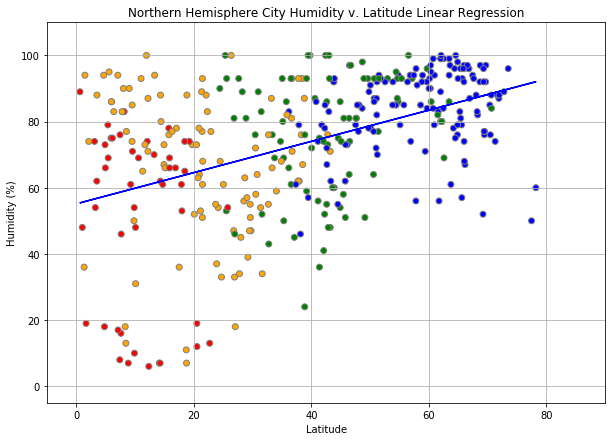

In [41]:
# Provide a brief explanation of what is being charted
print(f"The next two charts plot each city's % Humdity against the city's latitude.")
print("This first chart plots Northern Hemisphere cities. The color is there to add that 3rd dimension: temp.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_north["Lat"], df_weather_north["Humidity"], df_weather_north["Color"], 
                     "Humidity (%)", -5, 90, -5, 110, 
                     "Northern Hemisphere City Humidity v. Latitude Linear Regression", "NH_HumidvLat.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

And here is the same chart for cities in the Southern Hemisphere. Again, color is there to add that 3rd dimension: temp.
-----------------------
OBSERVATIONS:
* The plot for the Northern Hemisphere seems completely counter-intuitive.
    - I just never expected the coldest climates to have the highest humidity, Winter or Summer.
* For the Southern Hemisphere, the chart is as expected except for how flat it is.
    - But that may be because they are in the middle of their Summer with higher temps.
-----------------------
The correlation coefficient is: 0.16977323711669354


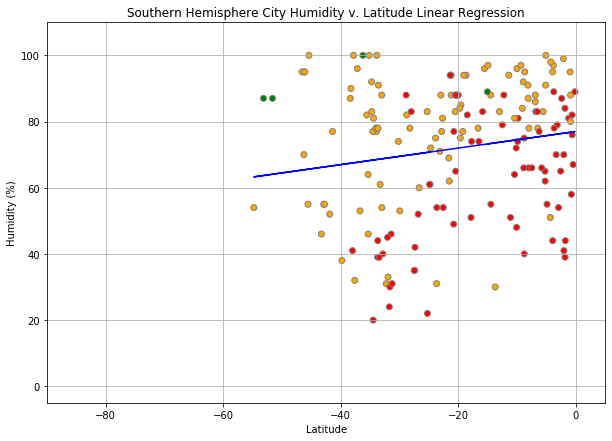

In [48]:
# Provide a brief explanation of what is being charted
print("And here is the same chart for cities in the Southern Hemisphere. Again, color is there to add that 3rd dimension: temp.")
print("-----------------------")
print("OBSERVATIONS:")
print("* The plot for the Northern Hemisphere seems completely counter-intuitive.")
print("    - I just never expected the coldest climates to have the highest humidity, Winter or Summer.")
print("* For the Southern Hemisphere, the chart is as expected except for how flat it is.")
print("    - But that may be because they are in the middle of their Summer with higher temps.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_south["Lat"], df_weather_south["Humidity"], df_weather_south["Color"], 
                     "Humidity (%)", -90, 5, -5, 110, 
                     "Southern Hemisphere City Humidity v. Latitude Linear Regression", "SH_HumidvLat.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The next 2 charts correlate well with the humidity plots by plotting Latitude v. Cloudiness.
This first chart plots only the cities in the Northern Hemisphere.
-----------------------
The correlation coefficient is: 0.28253488965275014


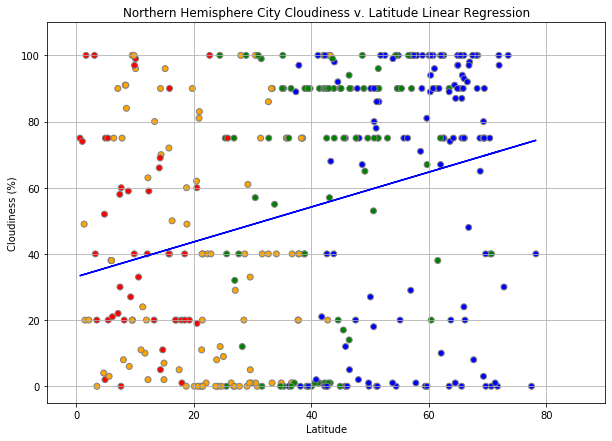

In [43]:
# Provide a brief explanation of what is being charted
print(f"The next 2 charts correlate well with the humidity plots by plotting Latitude v. Cloudiness.")
print(f"This first chart plots only the cities in the Northern Hemisphere.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_north["Lat"], df_weather_north["Cloudiness"], df_weather_north["Color"], 
                     "Cloudiness (%)", -5, 90, -5, 110, 
                     "Northern Hemisphere City Cloudiness v. Latitude Linear Regression", "NH_CloudsvLat.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Here is a similar plot to the one above but this time with only cities in the Southern Hemisphere.
-----------------------
Observations:
* Like the Humidity plots before, we see higher cloudiness in the colder climates (Northern Hemisphere).
* And in the Southern Hemisphere it gets more cloudy as you approach the equator.
-----------------------
The correlation coefficient is: 0.13473372972161662


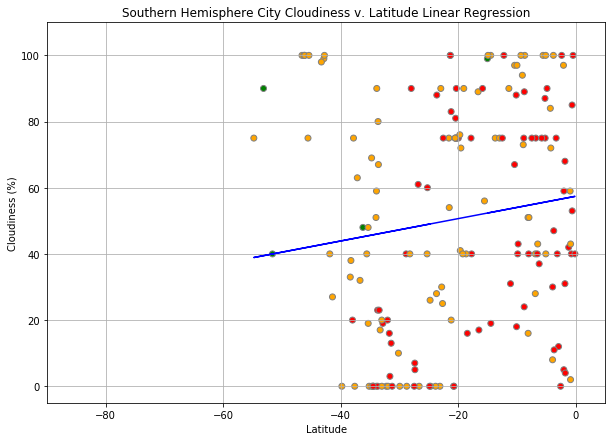

In [47]:
# Provide a brief explanation of what is being charted
print(f"Here is a similar plot to the one above but this time with only cities in the Southern Hemisphere.")
print("-----------------------")
print("Observations:")
print("* Like the Humidity plots before, we see higher cloudiness in the colder climates (Northern Hemisphere).")
print("* And in the Southern Hemisphere it gets more cloudy as you approach the equator.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_south["Lat"], df_weather_south["Cloudiness"], df_weather_south["Color"], 
                     "Cloudiness (%)", -90, 5, -5, 110, 
                     "Southern Hemisphere City Cloudiness v. Latitude Linear Regression", "SH_CloudsvLat.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

In the following 2 charts, We are plotting each city's latitude against the current wind speed.
-----------------------
First, we plot only cities in the Northern Hemisphere.
-----------------------
The correlation coefficient is: 0.15772465357556417


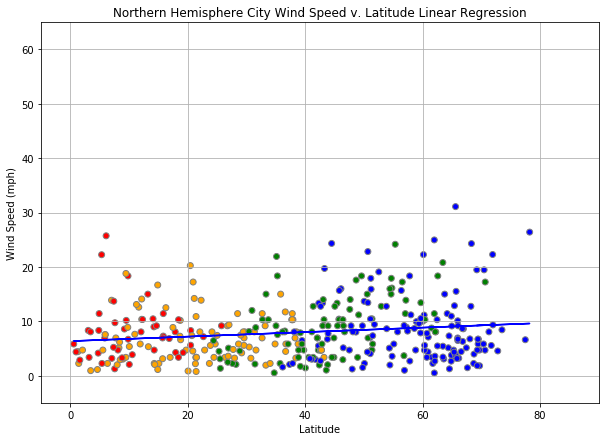

In [51]:
# Provide a brief explanation of what is being charted
print("In the following 2 charts, We are plotting each city's latitude against the current wind speed.")
print("-----------------------")
print("First, we plot only cities in the Northern Hemisphere.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_north["Lat"], df_weather_north["Wind"], df_weather_north["Color"], 
                     "Wind Speed (mph)", -5, 90, -5, 65, 
                     "Northern Hemisphere City Wind Speed v. Latitude Linear Regression", "NH_WindvLat.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

And now we plot cities in the Southern Hemisphere.
-----------------------
Observations:
* The regression lines for both Hemispheres are relatively flat, especially for the South.
* Also, the North is much more windy than the South.
* All of these charts highlight another major difference between the two Hemispheres.
    - There aren't many cities between the -60 and -100 latitude lines.
    - But the Northern Hemisphere has lots of cities between 60 and 100.
-----------------------
The correlation coefficient is: -0.20310503128169002


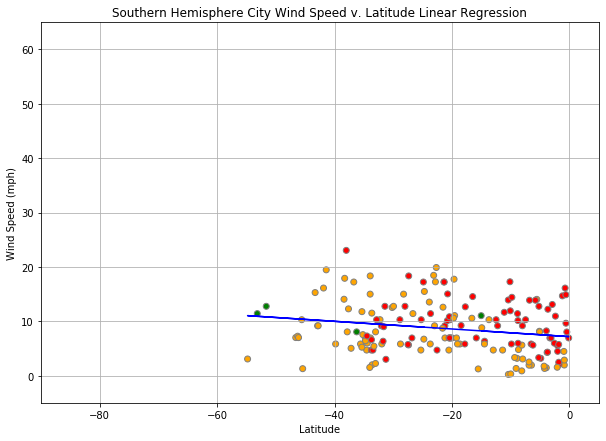

In [50]:
# Provide a brief explanation of what is being charted
print(f"And now we plot cities in the Southern Hemisphere.")
print("-----------------------")
print("Observations:")
print("* The regression lines for both Hemispheres are relatively flat, especially for the South.")
print("* Also, the North is much more windy than the South.")
print("* All of these charts highlight another major difference between the two Hemispheres.")
print("    - There aren't many cities between the -60 and -100 latitude lines.")
print("    - But the Northern Hemisphere has lots of cities between 60 and 100.")
print("-----------------------")

# Call our function to plot the regression chart
PlotLinearRegression(df_weather_south["Lat"], df_weather_south["Wind"], df_weather_south["Color"], 
                     "Wind Speed (mph)", -90, 5, -5, 65, 
                     "Southern Hemisphere City Wind Speed v. Latitude Linear Regression", "SH_WindvLat.png")